In [1]:
import time
import datetime
import numpy as np
import pandas as pd
from scipy import stats
# pd.set_option('display.max_columns', None)
from tqdm import tqdm, tgrange

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
matplotlib.rcParams['font.family'] = 'Malgun Gothic'

from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lasso, ElasticNet

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor 

import warnings
warnings.filterwarnings('ignore')

#### 1번째 데이터

In [2]:
# 2008 ~ 2009년 월별 헌혈 통계 읽기.
df1 = pd.read_csv('data/월별_헌혈통계_2005_2009.csv', encoding = 'euc-kr', header=None)
df_2008  = df1.iloc[:,-50:]
col_name = df_2008.loc[1]
df_2008.columns = col_name.tolist()
df_2008.drop(['합계'], axis=1, inplace=True)
year = df_2008.iloc[:1,0::2]
df_2008 = pd.concat([year, df_2008.iloc[3:,0::2]])

# 2010 ~ 2019년 월별 헌혈 통계 읽기.
df2 = pd.read_csv('data/월별_헌혈통계_2010_2019.csv', encoding = 'euc-kr', header=None)
col_name = df2.loc[1]
df2.columns = col_name.tolist()
df2.drop(['합계','혈액원별(1)','혈액원별(2)','성별(1)'], axis=1, inplace=True)
year = df2.iloc[:1,::2]
df_2019 = pd.concat([year,df2.iloc[3:,0::2]])

# 제거한 구분 컬럼명 생성.
idx_name = pd.concat([df1.iloc[:1,1:3], df1.iloc[3:,1:3]])
idx_name.columns = ['구분1', '구분2']

# 2008 ~ 2019년 실적 데이터 결합.
data1 = pd.concat([df_2008, df_2019],axis=1)
data1 = data1.apply(pd.to_numeric, errors = 'coerce')
data1 = pd.concat([idx_name, data1], axis=1)

# # 저장.
# data1.to_csv('data_month(실적).csv', encoding='utf-8-sig', index=False)  

In [3]:
# 데이터 복사 및 정보 확인.
df_1 = data1.copy().T

# 인덱스 6 : 전국 실적 합계를 의미.
# 인덱스 6만 학습시 사용.
df_2 = df_1.iloc[:, [4]]

In [4]:
# 필요없는 부분 제거.
df_2 = df_2[2:]
df_2 = df_2.astype(float)

In [5]:
# 결측치 확인.
df_2.isna().sum()

6    0
dtype: int64

In [6]:
# 인덱스 및 변수 재설정.
df_2.set_index([pd.date_range('2008-01-01', '2019-12-31', freq='MS').strftime('%Y-%m')], inplace=True)
df_2['year']  = pd.to_datetime(df_2.index).year
df_2['month'] = pd.to_datetime(df_2.index).month
df_2.columns  = ['총실적', '년도', '월']
df_2

,총실적,년도,월
2008-01,195331.0,2008,1
2008-02,149279.0,2008,2
2008-03,181270.0,2008,3
2008-04,186872.0,2008,4
2008-05,197322.0,2008,5
...,...,...,...
2019-08,218973.0,2019,8
2019-09,199670.0,2019,9
2019-10,221125.0,2019,10
2019-11,228662.0,2019,11


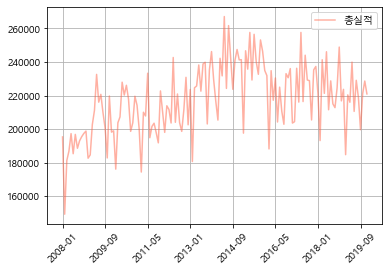

In [7]:
# 2008 ~ 2019 년까지의 월별 실적 추이.
df_2['총실적'].plot(kind='line', c='tomato', alpha=.5)
plt.xticks(rotation = 45)
plt.legend()
plt.grid()
plt.show()

#### 2번째 데이터

In [8]:
df_3 = pd.read_csv('data/수혈용_혈액_월평균_보유_추이_2005_2019.csv', encoding = 'euc-kr', header=None)
df_3 = df_3.iloc[:, 13:]
df_3 = df_3.iloc[:,::4].loc[3:]
df_3.columns = pd.date_range('2008-01-01', '2019-12-31', freq='Y').strftime('%Y').tolist()
df_3.set_index([list(range(1,13))], inplace=True)
df_3.T

,1,2,3,4,5,6,7,8,9,10,11,12
2008,14944,26184,22440,27666,30445,38299,33082,29812,32929,26206,23196,23056
2009,15362,16902,19336,24280,32388,48763,45879,44765,38823,23190,24864,38567
2010,24628,35290,25735,23268,29129,45600,50549,56008,60438,42764,41322,35854
2011,24418,24642,19292,21522,28063,35076,20834,16970,13961,13441,18183,19785
2012,14123,24209,19736,18544,30857,38934,32958,30954,22997,18690,24031,27137
2013,23459,28645,19920,34209,39483,44222,33953,38845,39229,22691,35947,36225
2014,31512,23104,21648,26077,36071,44292,38860,43801,32850,25344,29863,29829
2015,24397,27520,19122,20050,28680,32884,38645,31317,26048,17475,21705,16543
2016,15775,16547,15286,15690,27919,27836,21649,20410,15272,21288,24384,23674
2017,19365,18012,21423,19142,28126,37417,27288,37093,24333,18001,17241,21626


In [9]:
# 데이터 1열로 생성.
a2 = []
for i in range(2008, 2020) :
    a1 = df_3.T.loc[str(i)]
    a2.append(a1)
    
# 데이터 결합.
df_4 = pd.concat(a2, ignore_index=True)
df_4 = pd.DataFrame(df_4)
df_4.set_index([pd.date_range('2008-01-01', '2019-12-31', freq='MS').strftime('%Y-%m')], inplace=True)
df_4.columns = ['적혈구 혈액량']
df_4 = df_4.astype(float)
df_4

,적혈구 혈액량
2008-01,14944.0
2008-02,26184.0
2008-03,22440.0
2008-04,27666.0
2008-05,30445.0
...,...
2019-08,17882.0
2019-09,14835.0
2019-10,14707.0
2019-11,18255.0


In [10]:
# 결측치 확인.
df_4.isna().sum()

적혈구 혈액량    0
dtype: int64

#### 3번째 데이터

In [11]:
df_5= pd.read_csv('data/시·도별_인구대비_헌혈실적_2005_2019.csv', encoding = 'euc-kr', header=1)
df_5 = df_5.iloc[::]
df_5

,시·도별(1),헌혈실적 (건),헌혈률 (%),인구수 (명),헌혈실적 (건).1,헌혈률 (%).1,인구수 (명).1,헌혈실적 (건).2,헌혈률 (%).2,인구수 (명).2,...,인구수 (명).11,헌혈실적 (건).12,헌혈률 (%).12,인구수 (명).12,헌혈실적 (건).13,헌혈률 (%).13,인구수 (명).13,헌혈실적 (건).14,헌혈률 (%).14,인구수 (명).14
0,합계,2274336,4.7,48138077,2302542,4.8,48297184,2087762,4.3,48456369,...,50801405,2928670,5.7,51446201,2883270,5.6,51635256,2791092,5.4,51849861
1,서울,760596,7.6,10011324,793327,7.9,10020123,747542,7.5,10025669,...,9834687,1015159,10.4,9776305,975868,10.0,9721190,900964,9.3,9729107
2,부산,214551,6.0,3586087,213811,6.0,3554003,190408,5.4,3525220,...,3388631,215280,6.3,3428923,223730,6.5,3418011,213597,6.3,3413841
3,대구경북,195029,3.8,5158051,190002,3.7,5132158,158320,3.1,5104874,...,5092303,240804,4.7,5146365,246175,4.8,5141620,232482,4.6,5103867
4,인천,132426,5.1,2578356,123896,4.8,2596317,113310,4.3,2612866,...,2914455,163724,5.6,2923047,157493,5.4,2942005,158557,5.4,2957026
5,경기,139991,1.3,10612455,143177,1.3,10822060,130461,1.2,11039291,...,12519009,211129,1.6,12809379,204183,1.6,12955219,211443,1.6,13239666
6,강원,84507,5.7,1488365,77459,5.2,1479284,65018,4.4,1470447,...,1511017,154964,10.2,1520785,161359,10.6,1524406,153606,10.0,1541502
7,충북,77356,5.2,1484191,79003,5.3,1484406,72803,4.9,1483401,...,1566690,95644,6.0,1605139,93808,5.8,1612881,94251,5.9,1600007
8,대전세종충남,162539,4.8,3386798,147671,4.3,3404904,148281,4.3,3422910,...,3865321,242643,6.1,3954573,249417,6.2,4014115,249947,6.3,3939154
9,전북,120915,6.7,1816566,118604,6.6,1796572,98174,5.5,1770698,...,1800149,114233,6.2,1829707,108594,5.9,1827551,108908,6.0,1818917


In [12]:
# 결측치 확인.
df_5.isna().sum()

시·도별(1)        0
헌혈실적 (건)       0
헌혈률 (%)        0
인구수 (명)        0
헌혈실적 (건).1     0
헌혈률 (%).1      0
인구수 (명).1      0
헌혈실적 (건).2     0
헌혈률 (%).2      0
인구수 (명).2      0
헌혈실적 (건).3     0
헌혈률 (%).3      0
인구수 (명).3      0
헌혈실적 (건).4     0
헌혈률 (%).4      0
인구수 (명).4      0
헌혈실적 (건).5     0
헌혈률 (%).5      0
인구수 (명).5      0
헌혈실적 (건).6     0
헌혈률 (%).6      0
인구수 (명).6      0
헌혈실적 (건).7     0
헌혈률 (%).7      0
인구수 (명).7      0
헌혈실적 (건).8     0
헌혈률 (%).8      0
인구수 (명).8      0
헌혈실적 (건).9     0
헌혈률 (%).9      0
인구수 (명).9      0
헌혈실적 (건).10    0
헌혈률 (%).10     0
인구수 (명).10     0
헌혈실적 (건).11    0
헌혈률 (%).11     0
인구수 (명).11     0
헌혈실적 (건).12    0
헌혈률 (%).12     0
인구수 (명).12     0
헌혈실적 (건).13    0
헌혈률 (%).13     0
인구수 (명).13     0
헌혈실적 (건).14    0
헌혈률 (%).14     0
인구수 (명).14     0
dtype: int64

#### 4번째 데이터

In [13]:
# 헌혈자수, 헌혈율 등에 관하 데이터 읽기.
df_6 = pd.read_csv('data/헌혈자_수_2005_2019.csv', encoding = 'euc-kr')
df_6[3:].head(12)

,시점,총 헌혈실적 (건),총 인구 (명),헌혈률 (%),헌혈가능인구 (명),현혈가능인구대비 헌혈률 (%),헌혈자 수 (명),헌혈자 1인당 평균 헌혈실적 (건),실제 국민 헌혈률 (%)
3,2008,2347184,48948698,4.80,34708544,6.76,1526914,1.54,4.40
4,2009,2569954,49182038,5.23,34995947,7.34,1596809,1.61,4.56
5,2010,2664492,49410366,5.39,37138273,7.17,1657626,1.61,4.46
6,2011,2616575,49779440,5.26,37520772,6.97,1614036,1.62,4.30
7,2012,2722608,50004441,5.44,39645209,6.87,1653835,1.65,4.17
8,2013,2914483,50219669,5.80,38011521,7.67,1695193,1.72,4.46
9,2014,3053425,50423955,6.06,38249085,7.98,1696095,1.80,4.43
10,2015,3082918,50617045,6.09,38728606,7.96,1668424,1.85,4.31
11,2016,2866330,50801405,5.64,36757735,7.80,1596294,1.80,4.34
12,2017,2928670,51446201,5.69,39399676,7.43,1545022,1.80,3.92


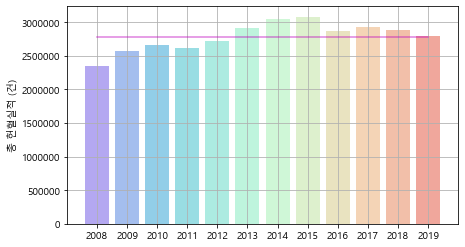

In [14]:
# 가장 헌혈 실적이 많았던 년도. : 2015년
# 2012년까지는 전체 평균보다 낮은 헌혈 실적량을 가졌으며, 최근들어 다시 감소하는 양상을 보임.
# bar 그래프.
plt.figure(figsize=(7, 4))
sb.barplot(df_6['시점'][3:].values, df_6[3:]['총 헌혈실적 (건)'], palette='rainbow', alpha=.5)
total_mean = df_6[3:]['총 헌혈실적 (건)'].mean()
plt.plot([0, 11], [total_mean, total_mean], 'm-', alpha=.5)
plt.grid()
plt.show()

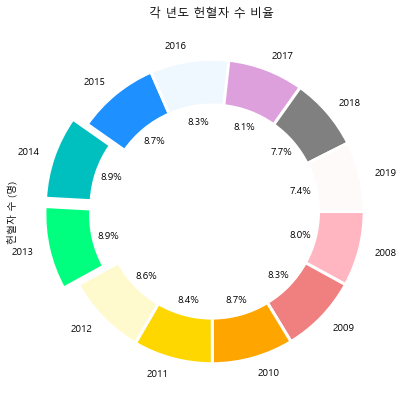

In [15]:
# 각 년도 헌혈자 수 비율. : 대체로 비슷한 양상을 보임. 2013 ~ 2014년 헌혈자 수 인구가 가장 많은 것으로 집계.
# Pie 차트 그래프. 
plt.figure(figsize=(9, 7))
col        = ['lightpink', 'lightcoral', 'orange', 'gold', 'lemonchiffon', 'springgreen', 
              'c', 'dodgerblue','aliceblue', 'plum','grey','snow']
explode    = (0, 0, 0, 0, 0, .1, .1, 0, 0, 0, 0, 0)
wedgeprops = {'width': 0.3, 'edgecolor': 'w', 'linewidth': 3}
label = df_6['시점'][3:].values
df_6[3:]['헌혈자 수 (명)'].plot(kind = 'pie', autopct='%.1f%%', colors = col, counterclock = False,
                         explode = explode, labels = label, wedgeprops = wedgeprops,  title='각 년도 헌혈자 수 비율')
plt.show()

In [16]:
# 학습에 사용될 년도별 헌혈류 변수.
df_7 = df_6[3:][['헌혈률 (%)']].rank(ascending = False)
df_7.set_index([pd.date_range('2008-01-01', '2019-12-31', freq='Y').strftime('%Y').tolist()], inplace=True)
df_7.columns = ['헌혈율 순위']
a2 = []
for n in df_2['년도'] :
    a1 = df_7.loc[str(n)]
    a2.append(a1)
df_8 = pd.DataFrame(a2)
df_8 = df_8.astype(int)
df_8.set_index([pd.date_range('2008-01-01', '2019-12-31', freq='MS').strftime('%Y-%m').tolist()], inplace=True)
df_8

,헌혈율 순위
2008-01,12
2008-02,12
2008-03,12
2008-04,12
2008-05,12
...,...
2019-08,9
2019-09,9
2019-10,9
2019-11,9


#### 5번째 데이터

In [17]:
# 데이터 읽기 및 재구성.
df_9 = pd.read_csv('data/연령별_헌혈통계_2005_2019.csv', encoding = 'euc-kr', header=None)
a1 = df_9.iloc[:,42:]
col_name = a1.loc[1]
a1.columns = col_name.tolist()
a1.drop(['합계'], axis=1, inplace=True)

# 각 년도별 연령별 실적 건.
a2 = a1.iloc[:,0::2]
a3 = a2.apply(pd.to_numeric, errors = 'coerce')
df_10 = a3.loc[[0, 6]].T
df_10.columns = ['년도', '연령별 총 헌혈수']
df_10['년도'] = df_10['년도'].astype(int)
df_10['년도'] = df_10['년도'].astype(str)
df_10

,년도,연령별 총 헌혈수
16~19세,2008,827189.0
20~29세,2008,1003958.0
30~39세,2008,283857.0
40~49세,2008,113426.0
50~59세,2008,33981.0
...,...,...
20~29세,2019,955947.0
30~39세,2019,396869.0
40~49세,2019,332103.0
50~59세,2019,146380.0


In [18]:
# 16~19세 : 2 , 20~29세 : 3, 30~39세 : 4, 40~49세 : 5, 50~59세 : 6, 60세이상 : 7
categori_list = []
for i in range(2008, 2020) :
    rank_list = []
    a1 = df_10[df_10['년도'] == str(i)]
    a2 = a1.iloc[:, -1].rank(ascending=False)
    rank_list.append(a2[a2 == 1].index)
    for r in rank_list :
        if r == '16~19세' :
            categori_list.append(2)
        elif r == '20~29세' :
            categori_list.append(3)
        elif r == '30~39세' :
            categori_list.append(4)
        elif r == '40~49세' :
            categori_list.append(5)
        elif r == '50~59세' :
            categori_list.append(6)
        else : 
            categori_list.append(7)
            
df_11 = pd.DataFrame(categori_list)
df_11.set_index([list(range(2008, 2020))], inplace=True)
df_11.columns = ['연령별 1순위 범주']

a3 = []
for n in df_2['년도'] :
    a1 = df_11.loc[n]
    a3.append(a1)
df_12 = pd.DataFrame(a3)
df_12 = df_12.astype(int)
df_12.set_index([pd.date_range('2008-01-01', '2019-12-31', freq='MS').strftime('%Y-%m').tolist()], inplace=True)
df_12

,연령별 1순위 범주
2008-01,3
2008-02,3
2008-03,3
2008-04,3
2008-05,3
...,...
2019-08,3
2019-09,3
2019-10,3
2019-11,3


#### 모델링

In [19]:
# 모델링 시키기 위한 Dataset 생성.
data_set = pd.concat([df_4, df_2, df_8, df_12], axis=1)

# 결과 데이터.
y_data = data_set['적혈구 혈액량']

# 특성 데이터.
x_data = data_set.iloc[:,1:]

display(y_data)
display(x_data)

2008-01    14944.0
2008-02    26184.0
2008-03    22440.0
2008-04    27666.0
2008-05    30445.0
            ...   
2019-08    17882.0
2019-09    14835.0
2019-10    14707.0
2019-11    18255.0
2019-12    21162.0
Name: 적혈구 혈액량, Length: 144, dtype: float64

,총실적,년도,월,헌혈율 순위,연령별 1순위 범주
2008-01,195331.0,2008,1,12,3
2008-02,149279.0,2008,2,12,3
2008-03,181270.0,2008,3,12,3
2008-04,186872.0,2008,4,12,3
2008-05,197322.0,2008,5,12,3
...,...,...,...,...,...
2019-08,218973.0,2019,8,9,3
2019-09,199670.0,2019,9,9,3
2019-10,221125.0,2019,10,9,3
2019-11,228662.0,2019,11,9,3


In [20]:
# 정상성 시계열 만들기.
x_dataList    = list(x_data.columns)
x_data_boxcox = x_data

# Box-cox transformaion
for i in x_data:
    for ii in np.arange(0, len(data_set)) :
        if x_data_boxcox[i][ii] == 0:
            x_data_boxcox[i][ii] = 1
            
    x_trans, _       = stats.boxcox(x_data_boxcox[i])
    x_data_boxcox[i] = x_trans

# Min-max로 값을 표준화 해줌.
x_data  = MinMaxScaler().fit_transform( x_data_boxcox ) 

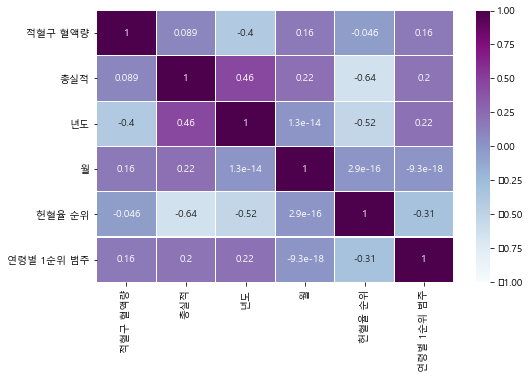

In [21]:
# 거의 연관성을 가지지 않아보임.
plt.figure(figsize=(8, 5))
sb.heatmap(data_set.corr(), vmin=-1, vmax=1, annot=True, linewidths=0.2, cmap='BuPu' )
plt.show()

In [22]:
# seed 값 설정.
np.random.seed(2021)

# 학습용 데이터셋과 검증용 데이터셋을 8 : 2로 분할.
n       = round(len(y_data)*0.8)
x_train = x_data[:n]
y_train = y_data[:n]

x_test  = x_data[n:]
y_test  = y_data[n:]

# 데이터들의 구성.
print(f'x_train shape : { x_train.shape }')
print(f'y_train shape : { x_train.shape }')
print(f'x_test shape  : { x_test.shape } ')
print(f'y_test shape  : { x_test.shape } ')

x_train shape : (115, 5)
y_train shape : (115, 5)
x_test shape  : (29, 5) 
y_test shape  : (29, 5) 


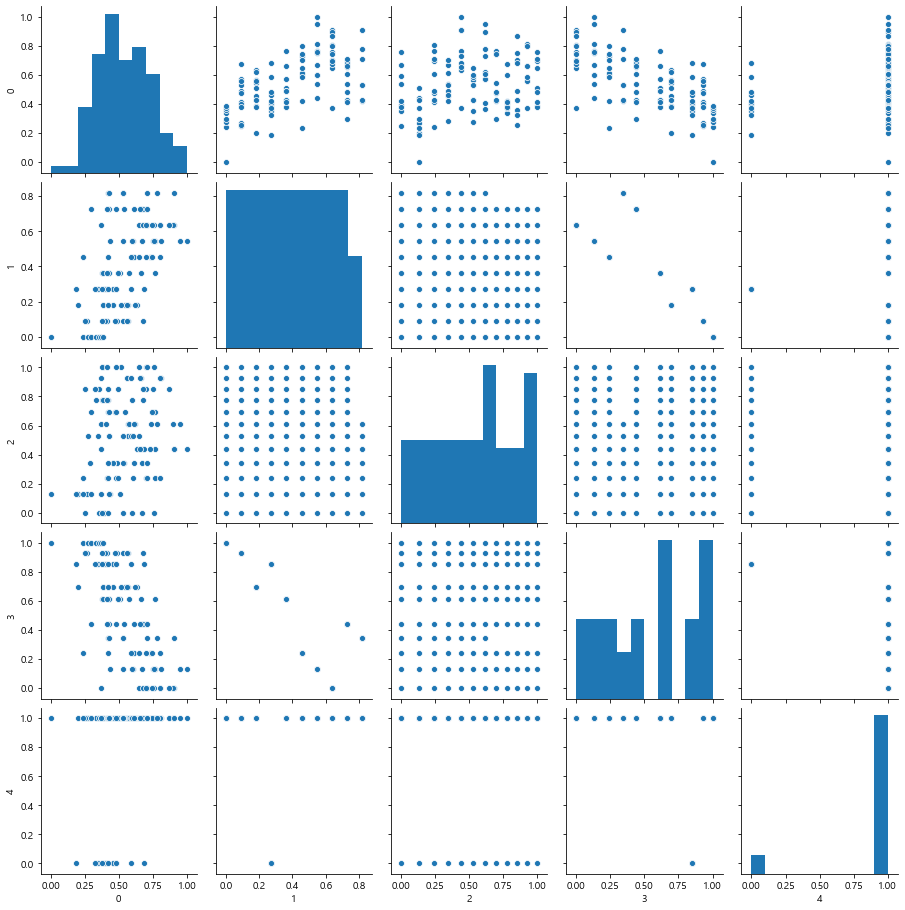

In [23]:
sb.pairplot(pd.DataFrame(x_train))
plt.show()

In [24]:
# GridSearch 
# 검증할 데이터 셋 분할 횟수 설정.
kf = KFold(n_splits = 10)

# 모델들을 담을 리스트 생성.
models         = []
Parameters     = []

# 모델 선택.
SGDR           = SGDRegressor(early_stopping=True)
lasso          = Lasso()
elastic        = ElasticNet()
MLP            = MLPRegressor(early_stopping=True)
RF             = RandomForestRegressor(oob_score=True )
KNN            = KNeighborsRegressor()

# 하이퍼 파라미터 튜닝.
Parameters_SGDR  = { 'alpha': [0.001, 0.01, 0.1] 
                  }

Parameters_lasso = {'alpha': [0.0001,0.001, 0.01, 0.1, 1, 2 ] }


Parameters_Elas  = {'alpha': [0.0001, 0.01, 0.1, 1, 2, 3],
                   'l1_ratio':[0.1,0.3,0.5,0.7,0.8]}


Parameters_MLP   = {'max_iter': [2000, 5000], 
                  'hidden_layer_sizes':[(100,2), (10,2) ], 
                  'learning_rate' : ['constant','adaptive'],
                 }

Parameters_RF    = {"max_features": [2,3,4],
                 "n_estimators" :[100,200,300]
                 }


Parameters_KNN   = {"n_neighbors": [3,5,7,9],
                  "weights": ['uniform','distance'],
                   "p":[1,2,3]
                 }

# 모델 담기.
models.append( SGDR )
models.append( lasso )
models.append( elastic )
models.append( MLP )
models.append( RF  )
models.append( KNN )

# 파라미터 담기.
Parameters.append( Parameters_SGDR )
Parameters.append( Parameters_lasso )
Parameters.append( Parameters_Elas )
Parameters.append( Parameters_MLP )
Parameters.append( Parameters_RF  )
Parameters.append( Parameters_KNN )

# 모델 이름.
model_name = ['SGDR', 'lasso', 'elastic', 'MLP', 'RF', 'KNN']

# 그리드 서치 함수 생성.
def gridSearchCV( models, params, count) :
    best_models = []
    for i in tqdm(range( 0, count )):
        model_grid = GridSearchCV( models[i], Parameters[i], cv = kf )
        model_grid.fit( x_train, y_train )
        best_models.append( model_grid.best_estimator_ )
    return best_models

best_model_list = gridSearchCV( models, Parameters, len(models) )

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:20<00:00,  3.42s/it]


In [25]:
# 평가 함수.
def Accuracy(index) :
    print(f'- Accuracy of {model_name[index]} model -')
    print('-'*135)
    print(f'Best Parameter                 : { best_model_list[index].get_params}')
    print(f'Accuracy of train data         : {round( best_model_list[index].score( x_train, y_train ), 2)*100 }%')
    print(f'Accuracy of test data          : {round( best_model_list[index].score( x_test, y_test ),   2)*100 }%')
    print('='*135)

In [26]:
# 평가 결과 보기.
for i in range( 0, len(models) ) :
    Accuracy(i)

- Accuracy of SGDR model -
---------------------------------------------------------------------------------------------------------------------------------------
Best Parameter                 : <bound method BaseEstimator.get_params of SGDRegressor(alpha=0.1, average=False, early_stopping=True, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)>
Accuracy of train data         : 8.0%
Accuracy of test data          : -463.0%
- Accuracy of lasso model -
---------------------------------------------------------------------------------------------------------------------------------------
Best Parameter                 : <bound method BaseEstimator.get_params of Lasso(alpha=2, copy_X=True, fit_intercept=True, m

In [27]:
# Voting model
model_vote = VotingRegressor( estimators = [(model_name[0], best_model_list[0]), (model_name[1], best_model_list[1]), 
                                             (model_name[2], best_model_list[2]), (model_name[3], best_model_list[3]),
                                             (model_name[4], best_model_list[4]), (model_name[5], best_model_list[5]),
                                            ])
model_vote.fit( x_train, y_train )

# Accuracy of voting.
print('- Accuracy of Voting -')
print('-'*130)
print(f'Accuracy of train data         : {round( model_vote.score( x_train, y_train ), 2)*100 }%')
print(f'Accuracy of test data          : {round( model_vote.score( x_test, y_test ),   2)*100 }%')
print('-'*130)


- Accuracy of Voting -
----------------------------------------------------------------------------------------------------------------------------------
Accuracy of train data         : 35.0%
Accuracy of test data          : 6.0%
----------------------------------------------------------------------------------------------------------------------------------
